# Regridding data using PyRho

## The PGrid Class

The `PGrid` object is defined by an N-dimensional numpy array `grid_data` and a N lattice vector given as a matrix `lattice`. The input array is a scalar field that is defined on a regularly spaced set of grid points starting at the origin. For example, you can construct a periodic field as follows:

In [ ]:
import numpy as np
from pyrho.pgrid import PGrid
from pyrho.vis.scatter import get_scatter_plot


def func(X, Y):
    return np.sin(X) * np.cos(2 * Y)


a = np.linspace(0, np.pi, 27, endpoint=False)
b = np.linspace(0, np.pi, 28, endpoint=False)
X, Y = np.meshgrid(a, b, indexing="ij")
data = func(X, Y)
pg2d = PGrid(grid_data=data, lattice=[[np.pi, 0], [0, np.pi]])

The data can be examined using the helper plotting function which supports up to 3-D.

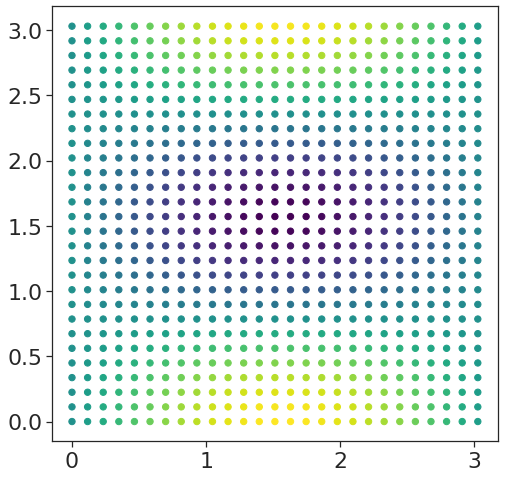

In [ ]:
import matplotlib as mpl

mpl.rc("image", cmap="viridis")
get_scatter_plot(pg2d.grid_data, pg2d.lattice, marker_size=40)

The period data in the PGrid object must be fixed-scaled so if you half the number of points in the domain, the range of the data will stay the same. This is different from how the charge density is stored in codes like VASP where the values at each point change based on the number of grid points used to store the data.

The regridding capabilities allow the user to obtain the data in any arbitrary representation. For example, if we want to shift to the middle of the unit-cell and create a ((1,1), (1,-1)) super-cell, with a 30 by 32 grid, we can run:

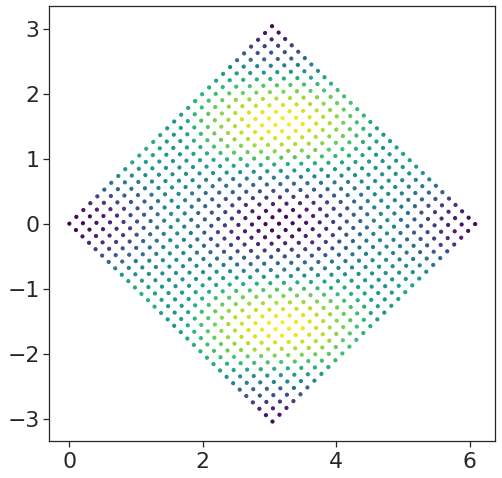

In [ ]:
pg_2x = pg2d.get_transformed([[1, 1], [1, -1]], origin=[0.5, 0.5], grid_out=[30, 32])
get_scatter_plot(pg_2x.grid_data, pg_2x.lattice, skips=1, opacity=1, marker_size=10)

# Up-sampling with Fourier interpolation

The up-sampling capabilities allow the user to exploit the periodicity of the data to obtain a higher-resolution grid.
As an example, we can take a sparsely sampled periodic data in 1-D:

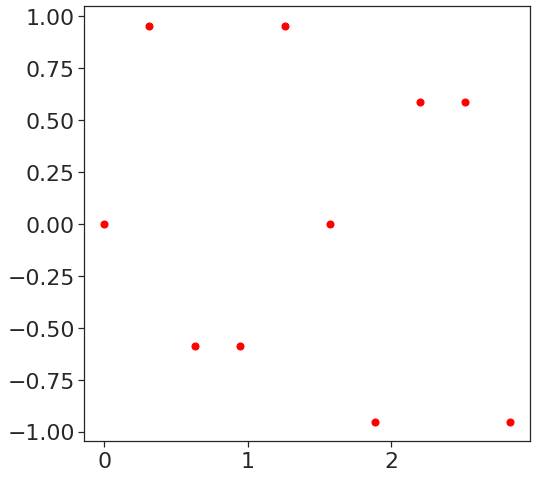

In [ ]:
def func1(X):
    return np.sin(6 * X)


a = np.linspace(0, np.pi, 10, endpoint=False)
data = func1(a)

pg1d = PGrid(grid_data=data, lattice=[[np.pi]])
get_scatter_plot(pg1d.grid_data, pg1d.lattice, marker_size=50)

This does not really resemble the `np.sin(6*X)` function we used to generate the data.
However, if we use an up-sample factor of 8, we can obtain a more dense representation:

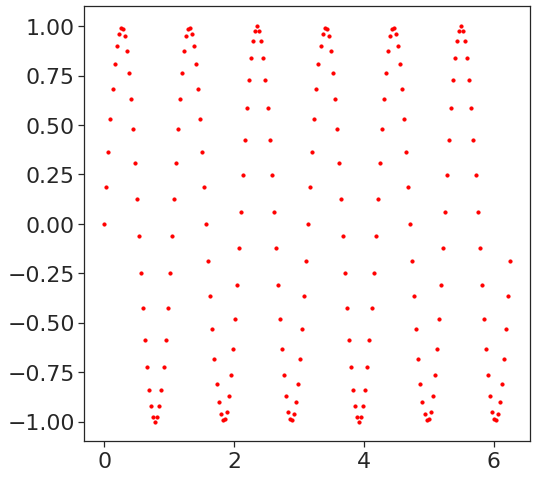

In [ ]:
pg1d_fine = pg1d.get_transformed(
    sc_mat=[[2]],
    grid_out=[
        200,
    ],
    up_sample=8,
)
get_scatter_plot(pg1d_fine.grid_data, pg1d_fine.lattice, marker_size=10)

## The ChargeDensity class

The `ChargeDensity` object can use the `from_file` construction methods from `pymatgen.io.vasp.outputs.Chgcar` as show below.
The `normalized_data` property contains a dictionary keyed with the same keys as `Chgcar.data` (typically "total" and "diff" for spin charge densities).


In [ ]:
from pymatgen.io.vasp import Chgcar
from pyrho.charge_density import ChargeDensity

cden_uc = ChargeDensity.from_file(
    "../test_files/CHGCAR.uc.vasp"
)
cden_sc = ChargeDensity.from_file(
    "../test_files/CHGCAR.sc1.vasp"
)
chgcar_sc = Chgcar.from_file(
    "../test_files/CHGCAR.sc1.vasp"
)
cden_transformed = cden_uc.get_transformed(
    [[1, 1, 0], [1, -1, 0], [0, 0, 1]],
    grid_out=cden_sc.grid_shape,
    up_sample=2,
)


In [ ]:
data = cden_uc.normalized_data["total"]
print(
    f"The normalized charge density data is has a range of {data.min():0.3f} --> {data.max():0.3f} e-/Ang^3"
)


The normalized charge density data is has a range of -0.188 --> 0.572 e-/Ang^3


Note that the PAW transformation sometimes results in negative charge densities.

In [ ]:
trans_data = cden_transformed.normalized_data["total"]
print(
    f"The transformed normalized charge density data is has a range of {trans_data.min():0.3f} --> {trans_data.max():0.3f} e-/Ang^3"
)


The transformed normalized charge density data is has a range of -0.188 --> 0.572 e-/Ang^3


In [ ]:
sc_data = cden_sc.normalized_data["total"]
print(
    f"The reference normalized charge density data is has a range of {sc_data.min():0.3f} --> {sc_data.max():0.3f} e-/Ang^3"
)


The reference normalized charge density data is has a range of -0.188 --> 0.570 e-/Ang^3


## Credits

Jimmy-Xuan Shen: Project lead

Wennie Wang: For naming the package
